# MC855 -  Atividade 1 

## Analise Exploratoria e Pre-Processamento do Dataset  

Lucas Xavier do Passo Suaide 182278

Arthur Rezende Salles da Costa 166003

Marcio Aparecido de Godoi Junior 252667



In [199]:
import os 
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import pandas as pd 
from sklearn.model_selection import train_test_split

plt.style.use('ggplot')

NON_CARDIO = ['Adductor' ,'ArmCurl' ,'BenchPress' ,'LegCurl' ,'LegPress', 'Squat' ]
CARDIO = ['Riding', 'RopeSkipping' ,'Running', 'StairClimber', 'Walking']

In [ ]:
raw_data = pd.read_csv("../data/RecGym.csv", index_col=0)
print(raw_data.dtypes)
print(raw_data.shape)
raw_data.head()

In [5]:
# Removing null entries 
raw_data['Workout'] = raw_data['Workout'].replace(to_replace='Null', value=None)
raw_data.dropna(inplace=True)

# printing all options for the dataset
for c in ['Subject', 'Position', 'Session', 'Workout']:
    print(f"{c} : {np.unique(raw_data[c].values)}")

print("--" * 40)
print("cardio exercises :",CARDIO)
print("non cardio exercises :", NON_CARDIO)
print("--" * 40)

# generating binary labels 
raw_data['label'] = np.where(raw_data['Workout'].isin(CARDIO), 1, 0)
raw_data['str-label'] = np.where(raw_data['Workout'].isin(CARDIO), 'CARDIO', 'NON_CARDIO')

Subject : [ 1  2  3  4  5  6  7  8  9 10]
Position : ['leg' 'pocket' 'wrist']
Session : [1 2 3 4 5]
Workout : ['Adductor' 'ArmCurl' 'BenchPress' 'LegCurl' 'LegPress' 'Riding'
 'RopeSkipping' 'Running' 'Squat' 'StairClimber' 'Walking']
--------------------------------------------------------------------------------
cardio exercises : ['Riding', 'RopeSkipping', 'Running', 'StairClimber', 'Walking']
non cardio exercises : ['Adductor', 'ArmCurl', 'BenchPress', 'LegCurl', 'LegPress', 'Squat']
--------------------------------------------------------------------------------


###  Sanity Check on the data

checking if each session has all the exercises and all sensors

In [200]:
df_view = raw_data[['Subject', 'Session', 'Workout', 'Position', 'str-label']]
df_view = df_view.drop_duplicates()

valid_positions = np.unique(raw_data['Position'].values)

pos_available = (
    df_view.assign(val=True).pivot_table(index=['Subject', 'Session', 'Workout'],
                                        columns='Position',
                                        values="val",  fill_value=0).reset_index()
)

# checking each sensor 
for sensor in ['leg', 'pocket', 'wrist']:
    query = f"{sensor} == 0"
    df = pos_available.query(query)
    print(f"Sensor evaluated : {sensor} - Missing Samples : {len(df)}")
    # display(df)



Sensor evaluated : leg - Missing Samples : 57
Sensor evaluated : pocket - Missing Samples : 5
Sensor evaluated : wrist - Missing Samples : 1


We will use only the `wrist` sensor. Since is the most feasible one for real life applications and also is the most present one

### Plotting data information

[ 0.   1.4  2.8  4.2  5.6  7.   8.4  9.8 11.2 12.6]
[25 25 25 23 25 25 25 25 25 25]
[30 30 30 29 30 29 30 30 29 30]


/tmp/ipykernel_5882/1395142806.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2].set_xticklabels(range(1, 11))


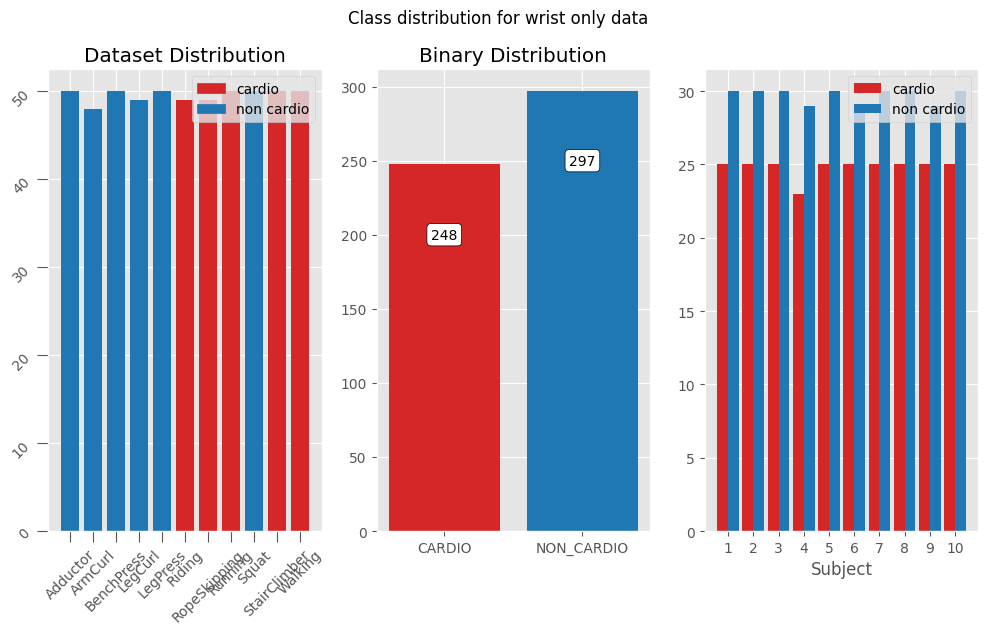

In [299]:
df_counter = df_view[df_view['Position'] == 'wrist']

original_dist = dict(df_counter.groupby('Workout').count()['str-label'])
binary_dist = dict(df_counter.groupby('str-label').count()['Subject'])
subject_dist = df_counter.groupby(['Subject', 'str-label']).count()['Session']


# original_dist
colors = ['tab:blue' if key in NON_CARDIO else 'tab:red' for key in original_dist]

red_patch = mpatches.Patch(color='tab:red', label='cardio')
blue_patch = mpatches.Patch(color='tab:blue', label='non cardio')


fig, ax = plt.subplots(1,3, figsize=(12,6))

fig.suptitle('Class distribution for wrist only data')

ax[0].set_title('Dataset Distribution')
ax[0].bar(original_dist.keys(), original_dist.values(), color=colors)
ax[0].tick_params(rotation=45,size=8)
ax[0].legend(handles=[red_patch, blue_patch])


ax[1].set_title('Binary Distribution')
ax[1].bar(binary_dist.keys(), binary_dist.values(), color=['tab:red', 'tab:blue'])


ax[1].text(0, 200, binary_dist['CARDIO'], size=10,
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec=(0, 0, 0),
                   fc=(1, 1, 1),
                   )
         )

ax[1].text(1, 250, binary_dist['NON_CARDIO'], size=10,
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec=(0, 0, 0),
                   fc=(1, 1, 1),
                   )
         )

# subject distribution  
width = 0.6

x = np.arange(10) * (1 + .4)

cardio = np.array([subject_dist[i]['CARDIO'] for i in range(1, 11)])
non_cardio = np.array([subject_dist[i]['NON_CARDIO'] for i in range(1, 11)])

print(x)
print(cardio)
print(non_cardio)


ax[2].bar(x - width/2, cardio, width, label="cardio", color='tab:red')
ax[2].bar(x + width/2, non_cardio, width, label="non cardio", color='tab:blue')
ax[2].set_xticklabels(range(1, 11))
ax[2].set_xticks(x)
ax[2].set_xlabel('Subject')

plt.legend()

# plt.tight_layout()
# plt.show()


### Split data into two types :

.   LOSO : Leave One Subject Out

.   70 / 20 / 10 : Training, Validation and Test

.   Time Validation : all samples from T1 to T3 as Training, T4 Validation and T5 to test


In [7]:
data_path = "../data"
base_path = os.path.join(data_path, "processed")

if not os.path.isdir(base_path):
    os.mkdir(base_path)

for (subject, session, exercise, pos, str_label), data in raw_data.groupby(by=['Subject', 'Session', 'Workout', 'Position' ,'str-label']):

    sub_path = os.path.join(base_path, f"subject_{subject}")
    if not os.path.isdir(sub_path):
        os.mkdir(sub_path)

    cardio_path = os.path.join(sub_path, f"{str_label}")
    if not os.path.isdir(cardio_path):
        os.mkdir(cardio_path)
    
    sub_session = os.path.join(cardio_path,f"session_{session}" )
    if not os.path.isdir(sub_session):
        os.mkdir(sub_session)
    
    file_path = os.path.join(sub_session, f"{exercise}_{pos}")
    data.to_csv(file_path + ".csv")
    # break
